In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import cv2


In [21]:
# path
path1 = '/content/pexels-pixabay-15239.jpg'
path2 = '/content/pexels-pixabay-65894.jpg'
  
# Using cv2.imread() method
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
  
# Displaying the image
# cv2.imshow('image', img1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (3000,3000))
img2 = cv2.resize(img2, (3000,3000))


In [22]:
# Assuming second image is added to first image
# Input the Gaussian kernel size and the percentage overlap (eg. 10%) of the second image to the first image

def superimposeImages(img1_, img2_, kernel_sz_x_, kernel_sz_y_, percOfOverlap):
    assert(img1_.shape == img2.shape)
    if(kernel_sz_x_ % 2 == 0):
        kernel_sz_x_ += 1
    if(kernel_sz_y_ % 2 == 0):
        kernel_sz_y_ += 1

    # cv2.normalize(img1)
    img1_normalized_ = cv2.normalize(img1_, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img2_normalized_ = cv2.normalize(img2_, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    blurred_img2_ = cv2.GaussianBlur(img2_normalized_,(kernel_sz_x_, kernel_sz_y_),0)
    # plt.imshow(blurred_img2_)
    return (img1_normalized_ * (1 - percOfOverlap / 100) + blurred_img2_ * percOfOverlap / 100)


(3000, 3000, 3)


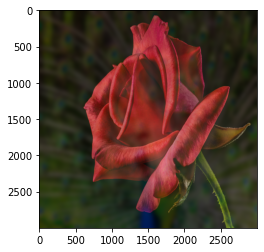

In [28]:
img = superimposeImages(img1, img2, 201, 201, 35)
plt.imshow(img)
img = np.array(img)
print(img.shape)

In [29]:
def grad(img):
    # only for single channel (pass each channel of RGB image separately)
    assert(len(img.shape) == 2)

    img_col = np.zeros_like(img)
    # shifting columns of img to the right by one unit
    img_col[:, :img.shape[1] - 1] = img[:, 1:]
    # last column is repeated
    img_col[:, img.shape[1] - 1] = img[:, -1]

    img_row = np.zeros_like(img)
    # shifting rows of img down by one unit
    img_row[:img.shape[0] - 1, :] = img[1:, :]
    # last row is repeated
    img_row[img.shape[0] - 1, :] = img[-1, :]

    # gradient in x and y
    grad_img = np.zeros((img.shape[0], img.shape[1], 2))
    grad_img[:, :, 0] = img_col - img
    grad_img[:, :, 1] = img_row - img

    return grad_img

def div(grad_img):
    # for 2 channel gradient inputs
    m, n, _ = grad_img.shape

    div_img = np.zeros((m, n))

    T = grad_img[:, :, 0]
    T1 = np.zeros_like(div_img)
    T1[:, 1:] = T[:, :(n-1)]

    div_img += (T - T1)

    T = grad_img[:, :, 1]
    T1 = np.zeros_like(div_img)
    T1[1:, :] = T[:(m-1), :]

    div_img += (T - T1)

    return div_img

# Solving (mu * (L ** 2) - lam * L + eps) * u = k
def poisson_dct(eq, mu, lam, eps):
    m, n = eq.shape

    k_list = np.arange(1, m+1).reshape(-1, 1)
    l_list = np.arange(1, n+1).reshape(-1, 1).T

    ones_n = np.ones((1, n))
    ones_m = np.ones((m, 1))

    k_list = np.cos((np.pi / m) * (k_list - 1))
    l_list = np.cos((np.pi / n) * (l_list - 1))

    k_list = np.kron(k_list, ones_n)
    l_list = np.kron(ones_m, l_list)

    kappa = 2 * (k_list + l_list - 2)
    const = (mu * (kappa ** 2)) - (lam * kappa) + eps

    u = scipy.fft.dctn(eq)
    u /= const
    u = scipy.fft.idctn(u)

    return u

def test_grad():
    grad_img0 = grad(img[:, :, 0])

    # display results
    plt.figure(figsize=(14,24))

    # show corners on original images
    ax = plt.subplot(1, 2, 1)
    plt.imshow(Image.fromarray(grad_img0[:, :, 0]))

    ax = plt.subplot(1, 2, 2)
    plt.imshow(Image.fromarray(grad_img0[:, :, 1]))

def test_div():
    grad_img0 = grad(img[:, :, 0])
    div_img0 = div(grad_img0)

    plt.imshow(Image.fromarray(div_img0))

def test_poissondct():
    grad_img0 = grad(img[:, :, 0])
    Laplacian = div(grad(div(grad_img0)))
    print(Laplacian.shape)
    out = poisson_dct(Laplacian, 1, 0, eps=1e-8)
    print(out.shape)

# test_grad()
# test_div()
# test_poissondct()

(3000, 3000, 3)
[-0.02684312 -0.02600074 -0.0251921  ...  0.89404535  0.8943933
  0.89606315]


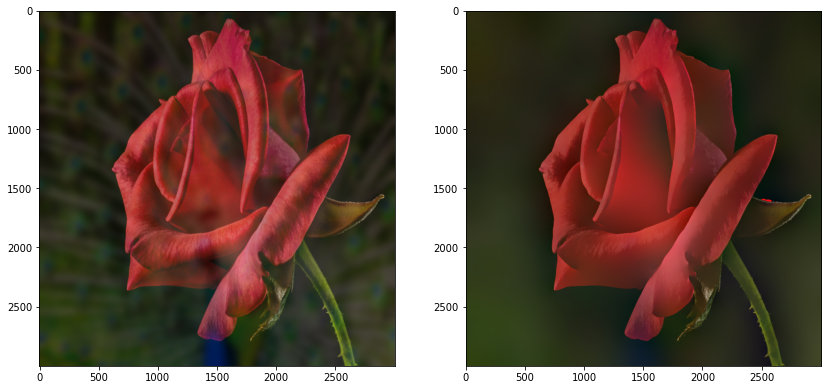

In [30]:
def closedform_reflectionsupp(img, thresh, eps):
    m, n, ch_dim = img.shape
    img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    eq = np.zeros_like(img)
    for ch_idx in range(ch_dim):
        grad_curr = grad(img[:, :, ch_idx])
        grad_norm_curr = np.linalg.norm(grad_curr, axis=2)

        grad_norm_thresh_curr = grad_norm_curr.copy()
        grad_norm_thresh_curr[grad_norm_curr < thresh] = 0

        zero_ind = (grad_norm_thresh_curr == 0)
        grad_curr[:, :, 0][zero_ind] = 0
        grad_curr[:, :, 1][zero_ind] = 0

        eq[:, :, ch_idx] = div(grad(div(grad_curr)))

    eq += (eps * img)

    T_img = np.zeros_like(img)
    for ch_idx in range(ch_dim):
        T_img[:, :, ch_idx] = poisson_dct(eq[:, :, ch_idx], 1, 0, eps)
    
    return T_img

T_img = closedform_reflectionsupp(img, thresh=0.033, eps=1e-8)
print(T_img.shape)
print(np.unique(T_img))
T_img = Image.fromarray((T_img * 255).astype(np.uint8))

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1, 2, 1)
plt.imshow(img)

ax = plt.subplot(1, 2, 2)
plt.imshow(T_img)

In [31]:
img = Image.open('woman.jpg')
img = np.array(img)

T_img = closedform_reflectionsupp(img, thresh=0.033, eps=1e-8)
print(T_img.shape)
print(np.unique(T_img))
T_img = Image.fromarray((T_img * 255).astype(np.uint8))

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1, 2, 1)
plt.imshow(Image.fromarray(img))

ax = plt.subplot(1, 2, 2)
plt.imshow(T_img)

FileNotFoundError: ignored